In [1]:
from pathlib import Path
from datetime import date

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#pd.set_option('display.max_rows',  None) #or 10 or None

path = Path(r'/Users/sr2/OneDrive - University College London/PhD/Research/'
        'Missions/SWARM/Non-Flight Data/Analysis/Mar-22/data/solar_max/')

dir_suffix = '2014'
pre_classified = str(path) + '/' + dir_suffix +'-data-2022-03-03.csv'
post_classified = str(path) + '/ml_model/SG-filtered_14-15.csv'

def open_all(filename):
    print('Loading data...')
    df = pd.read_csv(filename)
    return df
#df = open_all(load_all)
df = open_all(post_classified)

#Add delta changes
df['del_ne'] = df['Ne'].pct_change(periods=10)
df['del_pot'] = df['pot'].pct_change(periods=5)
df['del_ti'] = df['Ti'].pct_change(periods=10)

df= df.dropna()
df

Loading data...


,date,utc,mlt,lat,long,alt,s_id,p_num,b_ind,b_prob,...,Te_std,Ne_savgol,Ne_resid,sg_epb,sg_smooth,Ne_pc,Ne_stddev,del_ne,del_pot,del_ti
10,2014-09-16,00:54:58,0.336830,33.039500,-15.371248,6837897.26,A,34,0,0.0,...,0.001223,297508.791056,53.808944,0,0,0.007659,0.001756,0.044065,-0.004604,0.005475
11,2014-09-16,00:54:59,0.336484,32.975605,-15.371236,6837909.03,A,34,0,0.0,...,0.001178,298955.378137,484.321863,0,0,0.006308,0.001794,0.047666,-0.005530,0.005504
12,2014-09-16,00:55:00,0.336137,32.911711,-15.371231,6837920.81,A,34,0,0.0,...,0.001078,300494.603106,-201.403106,0,0,0.002850,0.001844,0.044161,-0.005535,0.004484
13,2014-09-16,00:55:01,0.335792,32.847816,-15.371232,6837932.59,A,34,0,0.0,...,0.000961,302105.929068,-102.429068,0,0,0.005695,0.001853,0.045944,-0.004617,0.004071
14,2014-09-16,00:55:02,0.335446,32.783922,-15.371238,6837944.37,A,34,0,0.0,...,0.000986,303847.959503,358.040497,0,0,0.007293,0.001932,0.050006,-0.005545,0.004588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883676,2015-02-02,23:59:55,22.923583,-4.906024,-8.412674,6838589.92,A,3528,0,0.0,...,0.004571,574375.967504,-16.167504,0,0,0.005506,0.002330,0.054472,0.002309,0.023576
1883677,2015-02-02,23:59:56,22.924578,-4.842117,-8.413883,6838579.48,A,3528,0,0.0,...,0.004538,577885.924167,-455.324167,0,0,0.005346,0.002330,0.053652,0.003468,0.022806
1883678,2015-02-02,23:59:57,22.925570,-4.778210,-8.415092,6838569.04,A,3528,0,0.0,...,0.004500,581493.796369,1049.903631,0,0,0.008855,0.002472,0.058510,0.002315,0.021979
1883679,2015-02-02,23:59:58,22.926559,-4.714303,-8.416301,6838558.58,A,3528,0,0.0,...,0.004444,585199.584111,384.215889,0,0,0.005219,0.002472,0.059385,-0.005747,0.021198


In [2]:
def transform_df(df):

    def groupby(df, feat, func_n, rename_col):
        func = getattr(df.groupby(['date','p_num'], as_index=False)[feat], func_n)
        df = func().rename(columns={feat:rename_col}).drop(columns=['date','p_num'])
        
        return df

    #min
    ne_min = df.groupby(['date','p_num'], as_index=False)['Ne'].min().rename(
            columns={'Ne':'ne_min'}) #unique. Because need the date and
    ti_min = groupby(df,'Ti','min','ti_min')
    pot_min = groupby(df,'pot','min','pot_min')

    #max
    ne_max = groupby(df,'Ne', 'max', 'ne_max')
    ti_max = groupby(df, 'Ti','max', 'ti_max')
    pot_max = groupby(df,'pot','max','pot_max')

    #mean
    ne_mean = groupby(df, 'Ne', 'mean', 'ne_mean')
    ti_mean = groupby(df, 'Ti', 'mean', 'ti_mean')
    pot_mean = groupby(df,'pot','mean','pot_mean')

    #stddev
    ne_std = groupby(df, 'Ne', 'std', 'ne_std')
    ti_std = groupby(df, 'Ti', 'std', 'ti_std')
    pot_std = groupby(df,'pot','std','pot_std')

    #delta
    ne_del = groupby(df, 'del_ne', 'max', 'ne_del')
    ti_del = groupby(df, 'del_ti', 'max', 'ti_del')
    pot_del = groupby(df, 'del_pot', 'max', 'pot_del')

    #EPB
    ibi_epb = groupby(df, 'b_ind', 'max', 'IBI')
    mssl_epb = groupby(df, 'sg_smooth','max','epb')
    ibi_size = groupby(df, 'b_ind', 'sum', 'ibi_size')
    mssl_size = groupby(df, 'sg_smooth', 'sum', 'epb_size')
    
    def epb_size_cal(df,col):
        df[col] = df[col] * 7.7
        return df
    
    ibi_size = epb_size_cal(ibi_size, 'ibi_size')
    mssl_size = epb_size_cal(mssl_size, 'epb_size')

    df = pd.concat([ne_min, ne_max, ne_mean, ne_std, ne_del,
        pot_min, pot_max, pot_mean, pot_std, pot_del,
        ti_min, ti_max, ti_mean, ti_std, ti_del,
        #ne_del, pot_del, ti_del,
        #ibi_epb, ibi_size, 
        mssl_size, mssl_epb], axis=1)

    df = df.sort_values(by=['date','p_num'], ascending=[True,True])


    return df

pd.set_option('display.max_rows',  10) #or 10 or None
df_gb = transform_df(df)
df_gb

,date,p_num,ne_min,ne_max,ne_mean,ne_std,ne_del,pot_min,pot_max,pot_mean,pot_std,pot_del,ti_min,ti_max,ti_mean,ti_std,ti_del,epb_size,epb
0,2014-02-01,2838,93003.3,114583.3,109189.571676,6504.295414,0.045535,-1.051,-0.984,-1.025127,0.021355,0.007921,1149.76,1190.81,1176.528960,11.792787,0.005569,0.0,0
1,2014-02-01,2839,97846.7,1585525.0,685650.681408,443342.275127,6.882411,-1.566,-0.459,-1.125415,0.207718,0.686275,1063.52,1949.10,1222.965686,110.166077,0.466179,1809.5,1
2,2014-02-01,2841,53225.1,1195532.7,428758.208346,424087.980321,1.623682,-1.574,-0.853,-1.007179,0.134017,0.262146,1065.55,2030.88,1181.566036,108.608006,0.779519,531.3,1
3,2014-02-01,2843,47012.8,724227.9,298335.639085,297802.742371,2.459978,-1.544,-0.874,-0.992158,0.106301,0.413346,1065.86,1606.44,1164.473486,82.885611,0.405496,215.6,1
4,2014-02-01,2845,41987.1,704825.6,251495.848880,241445.253199,2.244297,-1.628,-0.857,-1.037582,0.177174,0.171986,1065.40,1733.89,1149.940387,80.943665,0.457871,377.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,2015-10-27,566,72713.1,577715.5,214097.386364,114979.242663,0.123053,-1.276,-0.871,-1.043709,0.101148,0.199248,817.83,1385.05,1071.478987,169.616178,0.451326,0.0,0
2584,2015-10-27,568,63823.2,371674.0,186742.393052,95400.331554,0.134207,-1.335,-0.896,-1.088588,0.123293,0.212727,818.97,1301.12,1087.263690,144.161364,0.407475,0.0,0
2585,2015-10-27,570,86346.2,474384.1,222562.897556,112928.849745,0.460422,-1.347,-0.903,-1.065182,0.124096,0.218100,816.96,1367.05,1124.600865,156.271905,0.474521,0.0,0
2586,2015-10-27,572,92794.7,455566.1,186144.310542,95898.392812,0.896438,-1.338,-0.961,-1.114307,0.109897,0.185284,817.49,1337.08,1058.815743,171.639628,0.426241,0.0,0


In [3]:
#Tranform #2 using all data, not statistical overview

#df_gb = df.drop(columns=['date','b_ind','b_prob','utc','s_id'])
df_gb = df_gb.drop(columns=['date'])
df_gb

,p_num,ne_min,ne_max,ne_mean,ne_std,ne_del,pot_min,pot_max,pot_mean,pot_std,pot_del,ti_min,ti_max,ti_mean,ti_std,ti_del,epb_size,epb
0,2838,93003.3,114583.3,109189.571676,6504.295414,0.045535,-1.051,-0.984,-1.025127,0.021355,0.007921,1149.76,1190.81,1176.528960,11.792787,0.005569,0.0,0
1,2839,97846.7,1585525.0,685650.681408,443342.275127,6.882411,-1.566,-0.459,-1.125415,0.207718,0.686275,1063.52,1949.10,1222.965686,110.166077,0.466179,1809.5,1
2,2841,53225.1,1195532.7,428758.208346,424087.980321,1.623682,-1.574,-0.853,-1.007179,0.134017,0.262146,1065.55,2030.88,1181.566036,108.608006,0.779519,531.3,1
3,2843,47012.8,724227.9,298335.639085,297802.742371,2.459978,-1.544,-0.874,-0.992158,0.106301,0.413346,1065.86,1606.44,1164.473486,82.885611,0.405496,215.6,1
4,2845,41987.1,704825.6,251495.848880,241445.253199,2.244297,-1.628,-0.857,-1.037582,0.177174,0.171986,1065.40,1733.89,1149.940387,80.943665,0.457871,377.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2583,566,72713.1,577715.5,214097.386364,114979.242663,0.123053,-1.276,-0.871,-1.043709,0.101148,0.199248,817.83,1385.05,1071.478987,169.616178,0.451326,0.0,0
2584,568,63823.2,371674.0,186742.393052,95400.331554,0.134207,-1.335,-0.896,-1.088588,0.123293,0.212727,818.97,1301.12,1087.263690,144.161364,0.407475,0.0,0
2585,570,86346.2,474384.1,222562.897556,112928.849745,0.460422,-1.347,-0.903,-1.065182,0.124096,0.218100,816.96,1367.05,1124.600865,156.271905,0.474521,0.0,0
2586,572,92794.7,455566.1,186144.310542,95898.392812,0.896438,-1.338,-0.961,-1.114307,0.109897,0.185284,817.49,1337.08,1058.815743,171.639628,0.426241,0.0,0


Inspect the data statistically

In [4]:
pd.set_option('display.max_rows',  10) #or 10 or None
#df_gb.describe().transpose()

df_gb.dtypes


p_num         int64
ne_min      float64
ne_max      float64
ne_mean     float64
ne_std      float64
             ...   
ti_mean     float64
ti_std      float64
ti_del      float64
epb_size    float64
epb           int64
Length: 18, dtype: object

Split the data

In [5]:
column_indices = {name: i for i, name in enumerate(df_gb.columns)}

n = len(df_gb)
train_df = df_gb[0:int(n*0.7)]
val_df = df_gb[int(n*0.7):int(n*0.9)]
test_df = df_gb[int(n*0.9):]

#val_epb = val_df['epb']
#train_epb = train_df.pop('epb')
#test_epb = test_df['epb']

#print(train_df.describe().transpose())
#print(train_epb.describe().transpose())

print ('\n'.join([
    f'Train set size: {len(train_df)}',
    f'Val set size: {len(val_df)}',
    f'Test set size: {len(test_df)}',
    ]))

num_features = df_gb.shape[1]



Train set size: 1811
Val set size: 518
Test set size: 259


Normalise the data

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#train_df = pd.concat([train_df, train_epb], axis=1)
#val_df = pd.concat([val_df, val_epb], axis=1)
#test_df = pd.concat([test_df, test_epb], axis=1)

#print(train_df)

#train_df = tr_df
#val_df = v_df
#test_df = te_df

#print(train_df)


Examine the distribution of features. Some have long tails

          feats  feats norm
0         p_num    1.103605
1         p_num    1.104644
2         p_num    1.106721
3         p_num    1.108799
4         p_num    1.110876
...         ...         ...
30782  epb_size   -0.381071
30783  epb_size   -0.381071
30784  epb_size   -0.381071
30785  epb_size   -0.381071
30786  epb_size   -0.381071

[30787 rows x 2 columns]


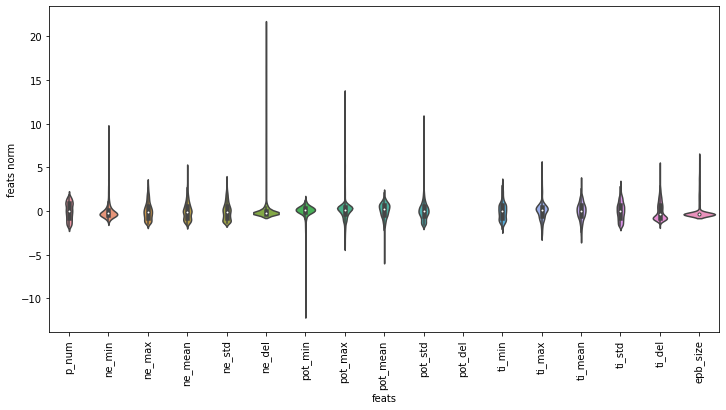

In [7]:
#df_gb.replace([np.inf, -np.inf], np.nan, inplace=True)

#print(train_df)

drop_epb_df = train_df.drop(columns=['epb'])
violin_df = drop_epb_df.melt(var_name='feats', value_name='feats norm')

print(violin_df)

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='feats', y='feats norm', data=violin_df)
_ = ax.set_xticklabels(drop_epb_df.keys(), rotation=90)


Data windowing

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Create window. 

Can we predict a bubble based on 32 tracks? (~1 days)

In [9]:
label_col = 'epb'
#input = tracks, label_width = labels to predict, #shift = amount to predict
w1 = WindowGenerator(input_width=16, label_width=1, shift=1,
                     label_columns=[label_col])
#w1

Split the data. Given a list, split it into a window of inputs and window labels

In [10]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

This is an example split

In [11]:
# Stack three slices, the length of the total window.
end_index = w1.total_window_size
example_window = tf.stack([np.array(train_df[:end_index]),
                           np.array(train_df[300:300+end_index]),
                           np.array(train_df[1200:1200+end_index])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time/input width, features)')
print ('\n'.join([
    f'Window shape: {example_window.shape}',
    f'Inputs shape: {example_inputs.shape}',
    f'Labels shape: {example_labels.shape}',
    ]))

All shapes are: (batch, time/input width, features)
Window shape: (3, 17, 18)
Inputs shape: (3, 16, 18)
Labels shape: (3, 1, 1)


2022-04-05 19:02:06.421930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plot

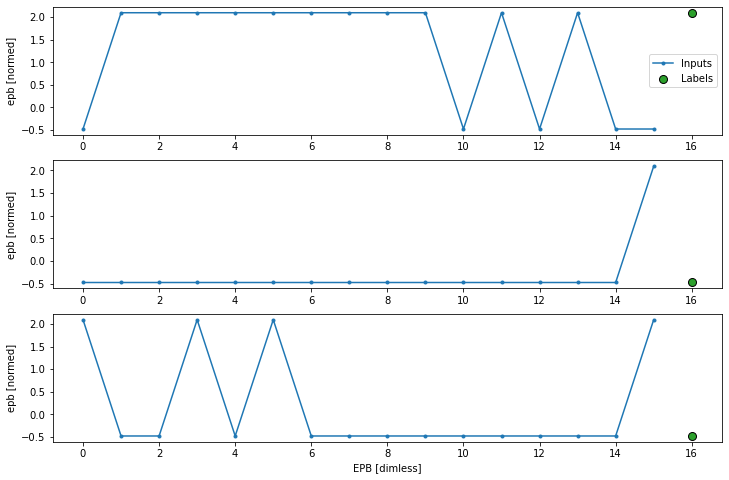

In [12]:
w1.example = example_inputs, example_labels

def plot(self, model=None, plot_col=label_col, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('EPB [dimless]')

WindowGenerator.plot = plot

w1.plot()

Create tf dataset

In [13]:
batch_size = 8

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  #ds = tf.keras.utils.timeseries_dataset_from_array(
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


#Add properties. The WindowGenerator object holds the training, val and test
#data
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Inspect the elements

In [14]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 16, 18)
Labels shape (batch, time, features): (8, 1, 1)


In [15]:
#Create data window for feeding into RNN
input_shape = 64
label_width = input_shape

wide_window = WindowGenerator(
    input_width=input_shape, label_width=label_width, shift=1,
    label_columns=['epb'])

wide_window

Total window size: 65
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
Label column name(s): ['epb']

Compile

In [16]:
MAX_EPOCHS = 8

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(
                loss=tf.losses.MeanSquaredError(),
                #loss = 'mean_square_error',
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Build and compile

In [17]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32,return_sequences=True),
    #tf.keras.layers.LSTM(units=128,return_sequences=True),
    #tf.keras.layers.LSTM(units=64,return_sequences=True),
    #tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(units=2)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
print(lstm_model.summary())

history = compile_and_fit(lstm_model, wide_window)

Input shape: (8, 64, 18)
Output shape: (8, 64, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (8, 64, 32)               6528      
                                                                 
 dense (Dense)               (8, 64, 2)                66        
                                                                 
Total params: 6,594
Trainable params: 6,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
219/219 [==============================] - 5s 15ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/8
219/219 [==============================] - 3s 14ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan


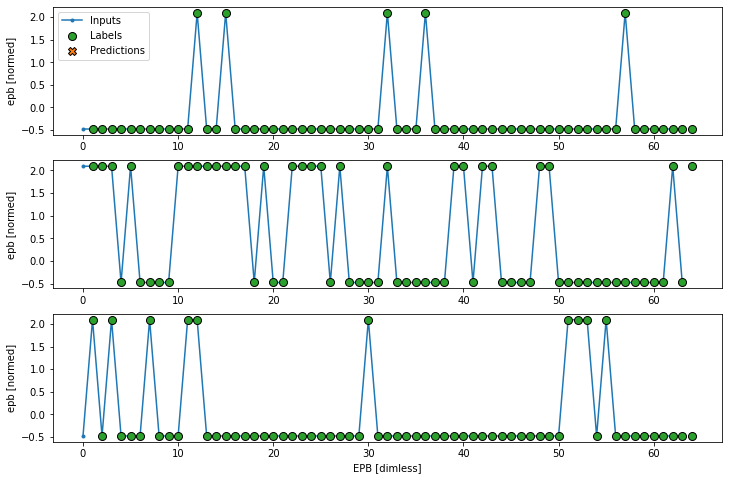

In [18]:
wide_window.plot(lstm_model)


In [19]:
history.history

{'loss': [nan, nan],
 'mean_absolute_error': [nan, nan],
 'val_loss': [nan, nan],
 'val_mean_absolute_error': [nan, nan]}